In [47]:
from typing import List, Dict, Union
from dataclasses import dataclass
import pickle
import json
import random
from itertools import chain

import gym
from gym.spaces import Box, Discrete, Tuple
from gym.utils import seeding
import simpy
from simpy.events import AnyOf, AllOf, Event

from utils import *

num_skipping_stop = 0
num_total_stop = 0


'''
By 12/07:
Todos (Simulator):
- [✅] Shift passenger arrival time
- [✅] Buses have to alight all passengers at terminals 
- [✅] Make buses stick to the schedule at terminal
- [ ] Fill action, state, reward buffers
- [✅ ] Make sure the plots make sense (No gap between buses at the terminal)
- [✅] Test skipping & turning around actions
- [ ] Calculate bus locations

Todos (RL):

'''


# event_buffer = {bus_id: {'ready': False, 'events': []} for bus_id in range(N_BUS)}

class Bus:
    def __init__(self, env, simpy_env, idx, starting_time) -> None:
        self.env = env
        self.simpy_env = simpy_env
        self.idx = idx
        self.capacity = CAPACITY
        self.cur_station = self.env.stations[0]
        self.next_station = self.cur_station
        #self.next_travel_time = self.env.get_travel_time(self.cur_station)
        self.next_travel_time = 0
        self.starting_time = starting_time
        # print(f'Bus {self.idx} is successfully initialized.')
        self.proc = self.simpy_env.process(self.drive())
        self.passengers = []
        self.num_pax = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.h_action = None
        self.l_action = None
        self.taking_action = False
        self.last_departure_time = starting_time
        self.action_start_time = None


    def drive(self):
        # hold at the terminal before starting to drive
        yield self.simpy_env.timeout(self.starting_time)
        self.env.departure_times.append(self.simpy_env.now)
        self.env.data[self.cur_station.idx].append(self.simpy_env.now)
        #print(f'Bus {self.idx} starts at {self.simpy_env.now}')

        # each cycle is a trip from one station to the next
        while True:
            turn_around = False

            # drive till the next station
            yield self.simpy_env.timeout(self.next_travel_time)
            if (len(self.env.departure_times) >= N_BUS) and (self.next_station.idx == 0):
                while (self.simpy_env.now < self.env.departure_times[-1] + HEADWAY):
                    yield self.simpy_env.timeout(self.env.departure_times[-1] + HEADWAY - self.simpy_env.now)
                self.env.departure_times.append(self.simpy_env.now)
            # request to enter the station
            self.env.ready = True
            self.taking_action = True
            self.env.acting_bus = self.idx
            self.action_start_time = self.simpy_env.now
            self.env.allow_skipping = (not any([pax.alight_station == self.next_station.idx for pax in self.passengers])) and (self.next_station.idx != 0) and (self.next_station.passengers)
            self.env.allow_turning_around = (self.next_station.idx != 0)

            yield self.simpy_env.timeout(0)

            # high-level and low-level actions
            h_action, l_action = self.env.action
            if h_action == 0:
                l_action = l_action[0] * THRESHOLD
            elif h_action == 2:
                l_action = l_action[1] * THRESHOLD
            else:
                l_action = 0
            self.h_action = h_action
            self.l_action = l_action
            # 0 means holding

            if h_action == 0 or self.next_station.idx in [N_STATION-1, int(N_STATION//2)-1]:
                with self.next_station.request() as req:
                    yield req
                    self.station_enter_time = self.simpy_env.now
                #print(f'Bus {self.idx} Arrives At Station {self.next_station.idx}')
                
                # if not any([pax.alight_station == self.next_station.idx for pax in self.passengers]):
                #     global num_skipping_stop
                #     num_skipping_stop = num_skipping_stop + 1
                # global num_total_stop               
                # num_total_stop += 1
                
                    self.env.data[self.next_station.idx].append(self.simpy_env.now)
                    if self.next_station.idx in [N_STATION-1, int(N_STATION//2)-1]:
                        pax_alight = self.alight_all_pax(self.next_station)
                        pax_board = 0
                    else:
                        pax_alight = self.alight_pax(self.next_station)
                        pax_board = self.board_pax(self.next_station)
                    holding_time = max(pax_board * t_b, pax_alight * t_a)
                    holding_time += l_action
                    self.station_holding_time = holding_time

                    yield self.simpy_env.timeout(holding_time)
                    self.update_state(h_action)
                    #print(f'Bus {self.idx} holds at station {self.cur_station.idx} for {holding_time} seconds')
                
            # 1 means skipping
            elif h_action == 1:
                yield self.simpy_env.timeout(0)
                self.update_state(h_action)
                #print(f'Bus {self.idx} skips station {self.cur_station.idx}')

            # 2 means turning around
            else: 
                turn_around = True

            if turn_around:
                # alight all passengers
                pax_alight = self.alight_all_pax(self.next_station) # then alight all other passengers
                holding_time = pax_alight * t_a
                # wait to alight all passengers
                yield self.simpy_env.timeout(holding_time)

                # turn around
                self.update_state(h_action)

                # wait to turn around
                yield self.simpy_env.timeout(l_action)

                #print(f'Bus {self.idx} turns around at station {self.cur_station.idx} to {self.next_station.idx} for {l_action} seconds')
            self.taking_action = False
            self.last_departure_time = self.simpy_env.now

    def alight_all_pax(self, station):
        """
        1, alight all passengers that are on the bus
        2, return the number of passengers that are leaving
        3, update the number of passengers on the bus to 0
        4, update passengers' last_start_time

        Return:
            the number of passengers that are boarding
        """
        passengers_left = []
        for pax in self.passengers:
            if pax.alight_station != station.idx:
                pax.bus = None
                passengers_left.append(pax)
                pax.new_status = 0
            else:
                pax.new_status = 2
        num_pax = len(self.passengers)
        station.passengers.extend(passengers_left)
        station.passengers.sort(key=lambda x: x.start_time)
        self.passengers = []
        self.num_pax = 0
        return num_pax


    def alight_pax(self, station):
        """
        1, alight the passengers that are supposed to get off
        2, return the number of passengers that are leaving
        3, update the number of passengers on the bus

        Return:
            the number of passengers that are boarding
        """
        pax_alight = 0
        passengers = []
        for pax in self.passengers:
            if pax.alight_station == station.idx:
                pax_alight += 1
                pax.new_status = 2     
            else:
                passengers.append(pax)
        self.passengers = passengers
        self.num_pax = len(passengers)
        return pax_alight

    def board_pax(self, station):
        """
        1, move the passengers to the bus
        2, return the number of passengers that are boarding
        3, update the arrival time of the last bus
        4, remove the passengers that are boarding from the station
        5, update passengers' on station time

        Parameters:
            station: the station that the bus is arriving at
        
        Return:
            the number of passengers that are boarding
        """
        STOP_BOARDING = False
        passengers = []
        n = 0
        for pax in station.passengers:
            if (pax.start_time < self.simpy_env.now) and (pax.bus is None) and (not STOP_BOARDING):
                pax.bus = self.idx
                self.passengers.append(pax)
                self.num_pax += 1
                n += 1
                pax.new_status = 1
                if self.num_pax == self.capacity:
                    STOP_BOARDING = True
            else:
                passengers.append(pax)
                
        station.last_arrival_time = self.simpy_env.now
        station.passengers = passengers
        return n

    def update_state(self, h_action):
        if h_action == 2:
            self.cur_station = self.next_station
            self.next_station = self.next_station.get_opposite()
            self.next_travel_time = 0
        else:
            self.cur_station = self.next_station
            self.next_station = self.next_station.get_next()
            self.next_travel_time = self.env.get_travel_time(self.cur_station)

    def get_observation(self):
        # state should include [location, headway, ego, pax, h_action, l_action]
        if self.starting_time > self.simpy_env.now:
            location = 0
        else:
            if self.taking_action:
                location = self.next_station.idx * STATION_DIST
            else:
                if self.next_travel_time == 0:
                    location = self.cur_station.idx * STATION_DIST
                else:
                    location = min(1, (self.simpy_env.now - self.last_departure_time) / self.next_travel_time) * STATION_DIST + self.cur_station.idx * STATION_DIST
        location = location % N_STATION
        action_duration = self.simpy_env.now - self.action_start_time if self.taking_action else 0
        return {'location': location,
                'pax': self.num_pax,
                'h_action': self.h_action if self.taking_action else None,
                'l_action': self.l_action if self.taking_action else None,
                'action_duration': action_duration,}

class Station:
    def __init__(self, 
                 env,
                 simpy_env, 
                 idx,
                 pax_alight,
                 pax_board) -> None:
        self.env = env
        self.simpy_env = simpy_env
        self.resource = simpy.Resource(simpy_env, capacity=1)
        self.idx = idx
        self.last_station = None
        self.next_station = None
        self.opposite_station = None
        self.pax_alight = pax_alight
        self.pax_board = pax_board
        self.passengers = self.generate_pax(self.pax_alight, self.pax_board)
        self.env.passengers.extend(self.passengers)
        self.last_arrival_time = 0

    def set_last(self, station):
        self.last_station = station

    def set_next(self, station):
        self.next_station = station

    def set_opposite(self, station):
        self.opposite_station = station

    def get_last(self):
        return self.last_station

    def get_next(self):
        return self.next_station

    def get_opposite(self):
        return self.opposite_station

    def request(self):
        return self.resource.request()

    def generate_pax(self, pax_alight, pax_board):
        return [Passenger(pax_board[i], pax_alight[i], pax_board[i]) for i in range((pax_board != np.inf).sum())] 


class Env(gym.Env):
    def __init__(self) -> None:
        self.travel_times = TABLE_TRAVEL_TIME
        self.pax_alight = PAX_ALIGHT_TABLE
        self.pax_board = PAX_ARRIVE_TABLE
        self.env = simpy.Environment()
        self.ready = False
        self.action = None
        self.departure_times = []
        self.passengers = []
        self.acting_bus = None
        self.allow_skipping = False
        self.allow_turning_around = False
        self.data = {station_idx: [] for station_idx in range(N_STATION)}

        self.stations = [Station(self, self.env, i, self.pax_alight[i], self.pax_board[i]) for i in range(N_STATION)]
        self.arange_stations()
        self.buses = [Bus(self, self.env, i, BUS_SCHEDULE[i]) for i in range(N_BUS)]
        
        self.last_timestep = 0
        self.acc_waiting_time = 0
        self.acc_on_bus_time = 0

        # run simulation until the first event
        while not self.ready:
            self.env.step()
        self.ready = False

        self.observation_space = Box(low=-1e4, high=1e4, shape=(N_BUS * FEATURE_DIM,))
        self.h_action_space = Discrete(3)
        self.l_action_space = Box(low=0, high=1, shape=(2,))
        self.action_space = Tuple((self.h_action_space, self.l_action_space))
        self.reset()

    def reset(self):
        self.env = simpy.Environment()
        self.passengers = []
        self.stations = [Station(self, self.env, i, self.pax_alight[i], self.pax_board[i]) for i in range(N_STATION)]
        self.arange_stations()
        self.buses = [Bus(self, self.env, i, BUS_SCHEDULE[i]) for i in range(N_BUS)]
        self.ready = False
        self.action = (0, (0, 0))
        self.departure_times = []
        self.data = {station_idx: [] for station_idx in range(N_STATION)}


        self.acc_waiting_time = 0
        self.acc_on_bus_time = 0

        # run simulation until the first event
        while not self.ready:
        # while self.env.now < 3600:
            self.env.step()
            self.get_reward()
        self.ready = False

        self.last_timestep = self.env.now
        obs = self.get_observation()
        return obs

    def arange_stations(self) -> None:
        for index, station in enumerate(self.stations):
            if index == len(self.stations)-1:
                station.set_next(self.stations[0])
            else:
                station.set_next(self.stations[index+1])
            
            if index == 0:
                station.set_last(self.stations[-1])
            else:
                station.set_last(self.stations[index-1])

            station.set_opposite(self.stations[len(self.stations) - index - 1])

    def step(self, action):
        self.action = action
        while not self.ready:
            self.env.step()
        # print("Environment Step")
        self.ready = False
        
        timestep = self.env.now - self.last_timestep
        self.last_timestep = self.env.now

        obs = self.get_observation()
        rewards = self.get_reward()
        done = self.env.peek() >= HORIZON - 2000
        info = {'timestep': timestep}
        
        return obs, rewards, done, info

    def action_masks(self):
        return [True, True, False]

    @staticmethod
    def extract_observations(obs):
        out = np.zeros((len(obs), 8))
        index = 0
        for k, (i, ob) in enumerate(obs):
            if ob['h_action'] is None:
                h_action = [0, 0]
            elif ob['h_action'] == 0:
                h_action = [1, 0]
            else:
                h_action = [0, 1]
            action_duration = 0 if ob['action_duration'] is None else ob['action_duration']
            l_action = 0 if ob['l_action'] is None else ob['l_action']
            processed_ob = [ob['ego'], ob['location'], ob['headway'], ob['pax'], action_duration] + h_action + [l_action]
            out[k] = processed_ob
            if ob['ego'] == 1:
                index = i
        out = np.roll(out, -index, axis=0)
        out = out[:, [2, 3]]
        return out


    def get_observation(self):
        def getHeadWay(self, loc1, loc2):
            t = int(self.env.now // TRAVEL_TIME_STEP)
            station1 = int(loc1 // STATION_DIST)
            station2 = int(loc2 // STATION_DIST)
            if station2 != station1:
                if station2 > station1:
                    headway = sum([self.travel_times[station1, int(self.env.now // TRAVEL_TIME_STEP)] for station1 in range(station1, station2)])
                else:
                    headway = sum([self.travel_times[station1, int(self.env.now // TRAVEL_TIME_STEP)] for station1 in chain(range(station1, N_STATION), range(0, station2))])
                headway += (loc2 - station2 * STATION_DIST) / STATION_DIST * self.travel_times[station2, int(self.env.now // TRAVEL_TIME_STEP)]
                headway += ((station1 + 1) * STATION_DIST - loc1) / STATION_DIST * self.travel_times[station1, int(self.env.now // TRAVEL_TIME_STEP)]
            else:
                headway = (loc2 - loc1) / STATION_DIST * self.travel_times[station1, int(self.env.now // TRAVEL_TIME_STEP)]
            return headway
            
        obs = {}
        for bus in self.buses:
            ob = bus.get_observation()
            if bus.idx == self.acting_bus:
                ob['ego'] = 1
            else:
                ob['ego'] = 0
            obs[bus.idx] = ob
        obs = sorted(obs.items(), key=lambda x: x[1]['location'])
        for index, (bus, ob) in enumerate(obs):
            ob['headway'] = getHeadWay(self, ob['location'], obs[(index+1)%len(obs)][1]['location'])
        
        obs = self.extract_observations(obs)
        obs = obs.reshape((-1)) # flatten the observation (96,)
        return obs


    def get_reward(self, obs=None):
        if obs is not None:
            reward = obs.std() ** 2
            return -reward
        alpha, beta = 1, 1
        waiting_time = 0
        on_bus_time = 0

        n_waiting_pax = 0
        n_on_bus_pax = 0
        for pax in self.passengers:
            if pax.status == 0 and pax.last_time < self.env.now:
                waiting_time += self.env.now - pax.last_time
                n_waiting_pax += 1
            elif pax.status == 1 and pax.last_time < self.env.now:
                on_bus_time += self.env.now - pax.last_time
                n_on_bus_pax += 1
            if pax.last_time < self.env.now:
                pax.last_time = self.env.now
                pax.status = pax.new_status
        # print('total num of pax: ', len([pax for pax in self.passengers if pax.start_time < self.env.now and pax.status != 2]))
        # print('total num of pax on bus: ', len([pax for pax in self.passengers if pax.status == 1]))    
        reward = alpha * waiting_time / max(1, n_waiting_pax) + beta * on_bus_time / max(1, n_on_bus_pax)
        self.acc_waiting_time += waiting_time
        self.acc_on_bus_time += on_bus_time
        return -beta * waiting_time

    def get_travel_time(self, station1):
        return self.travel_times[station1.idx, int(self.env.now // TRAVEL_TIME_STEP)]


@dataclass
class Passenger:
    start_time: float
    alight_station: int
    last_time: float
    bus: Bus = None
    status: int = 0 # 0: waiting, 1: on bus, 2: alighted
    new_status: int = 0 # 0: waiting, 1: on bus, 2: alighted



if __name__ == '__main__':
    env = Env()
    env.reset()
    action = (0, (0, 0))
    total_reward = 0
    while env.env.peek() < HORIZON - 2000:
        obs, rew, done, info = env.step(action)
        r = random.random()
        total_reward += rew
        # if r < 0.1 and env.allow_skipping:
        #     action = (1, 0)
        # elif r < 0.2:
        #     action = (2, 1)
        # else:
        #     action = policy(obs)
        # action = env.action_space.sample()   
        action = (0, (0, 0))
        # print(f'Current time: {env.env.now}')
    pickle.dump(env.data, open('data.pkl', 'wb'))
    print(env.departure_times)
    print('Total waiting time: ', env.acc_waiting_time)
    print('Total on bus time: ', env.acc_on_bus_time)
    print('stops allowde to skip: ', num_skipping_stop, ' ', num_total_stop)
    print('Total reward: ', total_reward)



[360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680, 5040.0, 5400.0, 5760.0, 6120.0, 6480.0, 6840.0, 7200.0, 7560.0, 7920.0, 8280.0, 8640.0, 9000.0, 9360.0, 9720.0, 10080.0, 10440.0, 10966.06847129254, 11326.06847129254, 11822.387846883988, 12277.229121990911, 12690.483347128287, 13060.563241408228, 13420.563241408228, 13780.563241408228, 14140.563241408228, 14500.563241408228, 14860.563241408228, 15220.563241408228, 15580.563241408228, 15940.563241408228, 16300.563241408228, 16660.56324140823, 17020.56324140823, 17380.56324140823, 17740.56324140823, 18100.56324140823, 18460.56324140823, 18820.56324140823, 19180.56324140823, 19540.56324140823]
Total waiting time:  79646412.0049771
Total on bus time:  0
stops allowde to skip:  0   0
Total reward:  -79644647.71357547


In [16]:
def gen():
    yield 'bread'

def gengen():
    while True:
        gen()


l = gengen()

KeyboardInterrupt: 

In [11]:
cnt

9

In [10]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
cars = [car(env, 'Car %d' % i, bcs, i*2, 5) for i in range(4)]
procs = [env.process(car.drive()) for car in cars]
global cnt
cnt = 0
def run(cars):
    global cnt
    while True:
        ret = yield AnyOf(env, [env.process(car.drive()) for car in cars])
        cnt += 1

env.process(run(cars))
env.run(until=100)

Car 0 arriving at 0
Car 0 arriving at 0
Car 0 starting to charge at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 arriving at 2
Car 2 arriving at 4
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 0 leaving the bcs at 5
Car 1 starting to charge at 5
Car 1 starting to charge at 5
Car 0 arriving at 5
Car 3 arriving at 6
Car 3 arriving at 6
Car 1 arriving at 7
Car 2 arriving at 9
Car 1 leaving the bcs at 10
Car 1 leaving the bcs at 10
Car 2 starting to charge at 10
Car 2 starting to charge at 10
Car 3 arriving at 11
Car 2 leaving the bcs at 15
Car 2 leaving the bcs at 15
Car 0 starting to charge at 15
Car 3 starting to charge at 15
Car 0 leaving the bcs at 20
Car 3 leaving the bcs at 20
Car 3 starting to charge at 20
Car 1 starting to charge at 20
Car 0 arriving at 20
Car 1 arriving at 22
Car 2 arriving at 24
Car 3 leaving the bcs at 25
Car 1 leaving the bcs at 25
Car 2 starting to charge at 25
Car 3 starting to charge at 25
Car 3 arriving at 26
Car 2 leaving the bcs at 30
C

In [4]:
import simpy
from simpy.events import AnyOf, AllOf, Event

class car:
    def __init__(self, env, name, bcs, driving_time, charge_duration):
        self.env = env
        self.name = name
        self.bcs = bcs
        self.driving_time = driving_time
        self.charge_duration = charge_duration
        #self.proc = env.process(self.drive())
        self.driving_times = 0

    def run(self):
        while True:
            self.drive()

    def drive(self):
        name, bcs, driving_time, charge_duration = self.name, self.bcs, self.driving_time, self.charge_duration
        # Simulate driving to the BCS
        yield env.timeout(driving_time)

        # Request one of its charging spots
        print('%s arriving at %d' % (name, env.now))
        with bcs.request() as req:
            yield req

            # Charge the battery
            print('%s starting to charge at %s' % (name, env.now))
            yield env.timeout(charge_duration)
            print('%s leaving the bcs at %s' % (name, env.now))
        self.driving_times += 1
        
# env = simpy.Environment()
# bcs = simpy.Resource(env, capacity=2)
# cars = [car(env, 'Car %d' % i, bcs, i*2, 5) for i in range(4)]
# procs = [env.process(car.run()) for car in cars]
# def run(cars):
#     while True:
#         ret = yield AnyOf(env, procs)
#         print(ret)

# env.process(run(cars))
# env.run(until=100)

In [15]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)

for i in range(4):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 5))

In [23]:
Event(env).env

In [10]:
from simpy.events import AnyOf, AllOf, Event
events = [Event(env) for i in range(3)]
a = AnyOf(env, events)  # Triggers if at least one of "events" is triggered.
b = AllOf(env, events)

In [19]:
def test_condition(env):
    t1, t2 = env.timeout(1, value='spam'), env.timeout(2, value='eggs')
    ret = yield t1 | t2
    print(env.now)
    assert ret == {t1: 'spam'}

    t1, t2 = env.timeout(1, value='spam'), env.timeout(2, value='eggs')
    ret = yield t1 & t2
    print(env.now)
    assert ret == {t1: 'spam', t2: 'eggs'}

    # You can also concatenate & and |
    e1, e2, e3 = [env.timeout(i) for i in range(3)]
    yield (e1 | e2) & e3
    print(env.now)
    assert all(e.processed for e in [e1, e2, e3])

env = simpy.Environment()
proc = env.process(test_condition(env))
env.run()

1
3
5


In [1]:
def act():
    yield 'hi'

In [8]:
def take_action():
    yield from act()

In [10]:
next(take_action())

'hi'

In [17]:
np.zeros((5,4))[1].shape

(4,)

In [9]:
import pickle
data = pickle.load(open('../data.pkl', 'rb'))

In [14]:
data_plot

array([[0,
        list([360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 6388.438810415332, 6736.9405814251295, 7221.468037225964, 7795.089002276407, 8441.569684842461, 8621.569684842461, 9061.601173346164, 9275.363852383027])],
       [0,
        list([360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 6388.438810415332, 6736.9405814251295, 7221.468037225964, 7795.089002276407, 8441.569684842461, 8621.569684842461, 9061.601173346164, 9275.363852383027])],
       [0,
        list([360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 6388.438810415332, 6736.9405814251295, 7221.468037225964, 7795.089002276407, 8441.569684842461, 8621.569684842461, 9061.601173346164, 9275.363852383027])],
       [0,
        list([360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 6388.438810415332, 6736.9405814251295, 7221.468037225964, 7795.089002276407, 8441.569684842461, 8621.569684842461, 9061.601173346164, 9275.363852383027])],
       [0,
        list([360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 6388.438810415332, 67

In [2]:
data

{0: [360,
  360,
  720,
  720,
  1080,
  1080,
  1440,
  1440,
  1800,
  1800,
  2160,
  2160,
  2520,
  2520,
  2880,
  2880,
  3240,
  3240,
  3600,
  3600,
  3960,
  3960,
  4320,
  4680,
  5266.8,
  5689.799999999999,
  6065.400000000001,
  6549.0,
  6934.2,
  7339.8,
  7699.8,
  8059.8,
  8419.8,
  8779.8,
  9139.8,
  10428.6,
  10788.6,
  11148.6,
  11508.6,
  11896.2,
  12256.2,
  12616.2,
  12976.2,
  13336.2,
  13696.2,
  14056.2,
  14416.2,
  16872.0,
  17232.0,
  17592.0,
  17952.0,
  18312.0,
  18672.0,
  19032.0,
  19392.0],
 1: [636.0,
  996.0,
  1356.0,
  1716.0,
  2076.0,
  2436.0,
  2796.0,
  3156.0,
  3516.0,
  3876.0,
  4236.0,
  4992.0,
  5566.8,
  5971.799999999999,
  6344.400000000001,
  6837.0,
  7213.2,
  7618.8,
  7975.8,
  8335.8,
  8695.8,
  9055.8,
  9415.8,
  10797.6,
  11064.6,
  11424.6,
  11784.6,
  12175.2,
  12532.2,
  12892.2,
  13252.2,
  13612.2,
  13972.2,
  14332.2,
  14692.2,
  17292.0,
  17508.0,
  17868.0,
  18228.0,
  18588.0,
  18948.0,
  193

<AxesSubplot: >

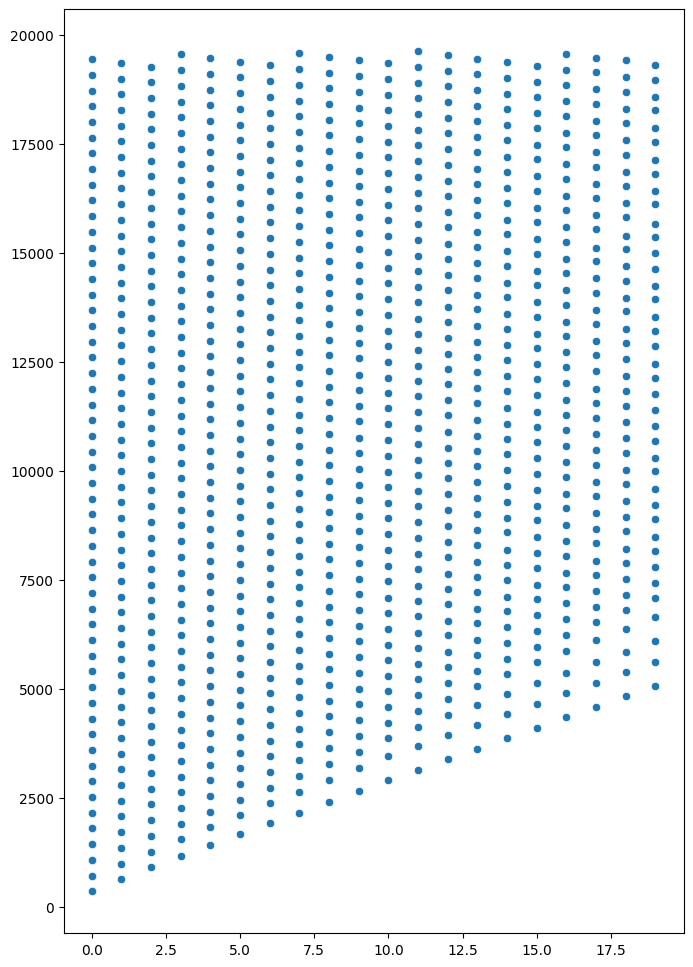

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
plt.figure(figsize=(8, 12))
data = pickle.load(open('data.pkl', 'rb'))
data_plot = np.array([[k, i] for k, v in data.items() for i in v])
sns.scatterplot(x=data_plot[:, 0], y=data_plot[:, 1])

In [54]:
from stable_baselines3 import PPO
model = PPO.load("./results/bus_env")

In [60]:
model.policy.action_net.weight

Parameter containing:
tensor([[ 0.0018,  0.0023,  0.0005,  0.0039,  0.0063],
        [-0.0069, -0.0046,  0.0005,  0.0038,  0.0073],
        [ 0.0044, -0.0037, -0.0052, -0.0005,  0.0005],
        [-0.0014,  0.0033, -0.0005, -0.0017,  0.0082],
        [-0.0018,  0.0052, -0.0020, -0.0007,  0.0011],
        [ 0.0019, -0.0026, -0.0003,  0.0020, -0.0003],
        [ 0.0035, -0.0007,  0.0031, -0.0044,  0.0031],
        [-0.0013,  0.0014, -0.0035,  0.0185, -0.0082],
        [ 0.0005,  0.0010, -0.0051, -0.0016,  0.0020],
        [ 0.0005,  0.0030,  0.0005, -0.0015, -0.0030],
        [-0.0013,  0.0004, -0.0009, -0.0015, -0.0016],
        [-0.0012, -0.0008, -0.0041, -0.0029, -0.0001]], requires_grad=True)

In [65]:
import torch
import torch.nn as nn

encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(12, 1, 512)
out = transformer_encoder(src)

In [6]:
import torch.nn as nn
import torch
nn.Linear(8, 32)(torch.zeros(12, 8)).size()

torch.Size([12, 32])

In [3]:
env = Env()
obs = env.reset()
model.predict(obs)

[(9, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (8, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (7, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (6, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (5, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (4, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (3, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (2, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'action_duration': 0, 'ego': 0, 'headway': 0.0}), (1, {'location': 0, 'pax': 0, 'h_action': None, 'l_action': None, 'acti

(array([0.619878], dtype=float32), None)

In [4]:
from stable_baselines3 import PPO
from DiscreteEnv import Env
import pickle

model = PPO.load("./results/bus_env_ppo_cont")

env = Env()
obs = env.reset()
while True:
    action, _ = model.predict(obs)
    obs, rewards, dones, info = env.step(action[0])
    print(obs)
    print(action)
    # if rendering
    if dones:
        break
pickle.dump(env.data, open('data.pkl', 'wb'))


[0, 1, 0, 240.0, 2400.0]
[0.]
[0, 0, 1.175, 0.0, 261.0]
[1.]
[0.475, 2, 0, 303.0, 2289.1945037888117]
[0.]
[0, 1, 2, 240.0, 240.0]
[1.]
[0, 0, 1, 0.0, 240.0]
[1.]
[1.2299999999999993, 3, 0, 332.4000000000001, 2160.0]
[1.]
[0, 2, 3, 360.0, 240.0]
[1.]
[0, 1, 2, 240.0, 240.0]
[1.]
[2, 4, 0, 360.0, 2075.415772258346]
[0.71449363]
[0, 0, 1, 0.0, 240.0]
[1.]
[1, 3, 4, 360.0, 240.0]
[0.43265796]
[0, 1, 1.7243133569843507, 263.2960487624871, 86.9176028381221]
[1.]
[1, 2, 3, 240.0, 240.0]
[0.7881098]
[3, 5, 0, 360.0, 1920.0]
[1.]
[0, 0, 1, 0.0, 240.0]
[1.]
[2, 4, 5, 360.0, 240.0]
[0.6532061]
[0.09840930949518452, 2, 2.156478026021216, 348.19088286057786, 18.777363122545943]
[1.]
[4, 6, 0, 380.70207129839395, 1909.691137512463]
[1.]
[2, 3, 4, 240.0, 240.0]
[1.]
[0, 1, 2, 240.0, 240.0]
[1.]
[0, 0, 1, 0.0, 240.0]
[0.35797834]
[3, 5, 6.152482739180054, 360.0, 258.29792870160645]
[0.06235385]
[1.9114417935497499, 3, 3, 250.62698477403, 0.0]
[1.]
[0.698245906829834, 2, 3, 276.2104911804199, 240.0]
[

In [2]:
_

In [66]:
out.size()

torch.Size([12, 1, 512])

In [9]:
from gym.spaces import Box

In [14]:
obs_space = Box(low=-1e4, high=1e4, shape=(96,))

In [15]:
obs_space.sample().shape

(96,)

In [16]:
class Student:
    def __init__(self, name, age):
        self.name = name
        self.age = age
    def __repr__(self):
        return 'Student(%s, %s)' % (self.name, self.age)

In [18]:
kwards = {'name': 'John', 'age': 20, 'hi': 1}
student = Student('John', 'age', **kwards)

TypeError: Student.__init__() got multiple values for argument 'name'

In [1]:
int(5.8//2)

2

In [4]:
from itertools import chain
list(chain(range(5), range(5)))

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]